In [11]:
# required imports
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
import ast
from escher import Builder
%matplotlib inline
import matplotlib.pyplot as plt
from vivarium.plots.topology import plot_topology
# Import the DynamicFBA class and the main function from the dFBA_process.py file
import sys
sys.path.append('../Models')
from dFBA_processes import DynamicFBA, ReactionBoundUpdater, main

In [12]:
# Set the desired model_path
model_path = "../SBML/e_coli_core.xml"
simulation_time = 50  # specify the desired simulation time in seconds
# Call the main function with the model path and simulation time
data, output, processes, topology = main(model_path, simulation_time)


Simulation ID: 8c3020d2-e5d5-11ed-a4f3-ba21c95c07d9
Created: 04/28/2023 at 11:01:26
Completed in 0.042968 seconds


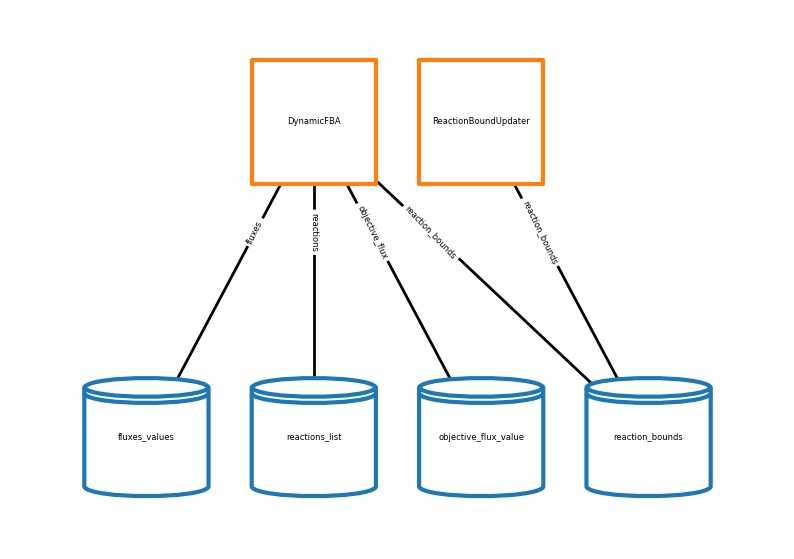

In [13]:
composite = {'processes': processes, 'topology': topology, 'steps': {}, 'flow': {}}
config = {'font_size': 6}
fig_topology = plot_topology(composite, config)

In [14]:
# extract the fluxes data
if isinstance(output, str):
    # convert the string to a dictionary
    output = ast.literal_eval(output)
flux_data = output[1]['fluxes_values']
reactions_data = output[1]['reactions_list']
objective_flux_data = output[1]['objective_flux_value']
reaction_bounds_data = output[1]['reaction_bounds']

In [15]:
# Escher
# Load the E. coli core map
builder = Builder(
    map_name="e_coli_core.Core metabolism",     # user should choose it.
    reaction_data=flux_data,
    show_gene_reaction_rules=False,
)

# Save the Escher plot as an HTML file
builder.save_html("../Plots/escher_plot__dFBA.html")

builder


Builder(reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 1.0297466822596379e-15, 'ACONTa': 6.00724957535035…

In [5]:
#data

NameError: name 'x_data' is not defined

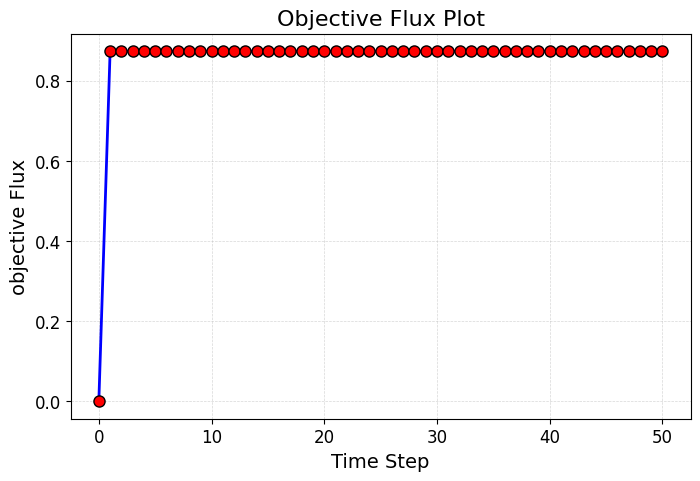

In [6]:
Time_step_data = []
objective_flux_data = []

for key, value in data.items():
    if 'objective_flux_value' in value:
        Time_step_data.append(key)
        objective_flux_data.append(value['objective_flux_value'])


plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(Time_step_data, objective_flux_data, marker='o', linestyle='-', linewidth=2, markersize=8, markerfacecolor='red', markeredgecolor='black', color='blue')

# Customize labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('objective Flux', fontsize=14)
plt.title('Objective Flux Plot', fontsize=16)

# Customize the grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Customize the axis limits and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.5, len(x_data)-0.5)



plt.show()